In [1]:
#Let's import the relevant libraries
from __future__ import print_function
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.preprocessing import image

from keras.optimizers import *
from keras.layers.normalization import BatchNormalization

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import cv2
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

/Users/emre/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#variables
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 128
epochs = 50

In [3]:
#Load the images
filename = '/Users/emre/DataIncubatorChallenge/denverEmotions/denverTraining.csv'

def getData(filname):
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y


X, Y = getData(filename)
num_class = len(set(Y))

In [4]:
#We need to preprocess the images to a certain format and divide them into 
#training and test groups as given in the dataset
for i in range(X.shape[0]):
    X[i,:,:,0] = cv2.equalizeHist(X[i,:,:,0].astype(np.uint8))

# Split in  training set : validation set :  testing set in 80:10:10
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)
    
x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')

In [5]:
#Main CNN model with four Convolution layer & two fully connected layer
def cnn_model():
    #construct CNN structure
    model = Sequential()
    
    #1st convolution layer
    model.add(Conv2D(32, (5, 5), padding='same', input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.15))
    
    #2nd convolution layer
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.15))
    
    #3rd convolution layer
    model.add(Conv2D(128, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.15))
    
    #4th convolution layer
    model.add(Conv2D(128, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.15))
    
    model.add(Flatten())
    #fully connected neural networks
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    #------------------------------
    #sgd = keras.optimizers.SGD(lr=0.1, decay=1e-4, momentum=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['categorical_accuracy'])

    return model

In [6]:
def vgg_saved():
    #load json and create model
    json_file = open('model_4layer_2_2_pool.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    #load weights from h5 file
    model.load_weights("model_4layer_2_2_pool.h5")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[categorical_accuracy])
    return model

In [7]:
# If model is not saved train the CNN model otherwise just load the weights
is_model_saved = True
if(is_model_saved==False ):
    # Train model
    model = cnn_model()
    # Note : 3259 samples is used as validation data &   28,709  as training samples

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=2,
              validation_split=0.1111)
    model_json = model.to_json()
    with open("model_4layer_2_2_pool.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model_4layer_2_2_pool.h5")
    print("Saved model to disk")
else:
    # Load the trained model
    model = vgg_saved()

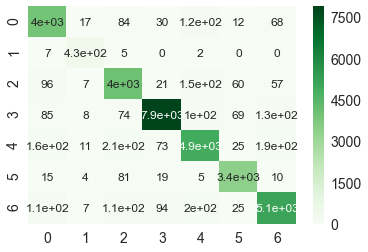

In [8]:
# Model will predict the probability values for 7 labels for a test image
predictions = model.predict(x_test)
new_X = [ np.argmax(item) for item in predictions ]
y_test2 = [ np.argmax(item) for item in y_test]
cm = confusion_matrix(new_X, y_test2)
sn.set(font_scale=1.4)#for label size
sn.heatmap(cm, annot=True, cmap = 'Greens',annot_kws={"size": 12})

In [9]:
#function for drawing bar chart for emotion preditions
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

/Users/emre/anaconda2/lib/python2.7/site-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


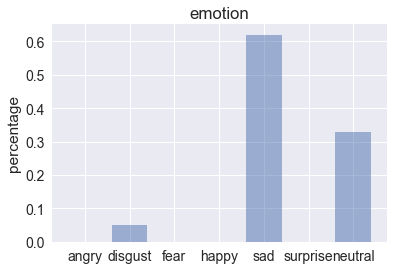

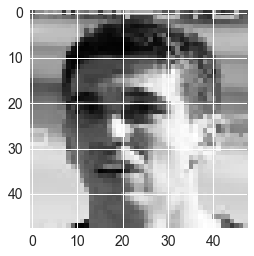

In [10]:
img = image.load_img("/Users/emre/DataIncubatorChallenge/denverEmotions/marathonPhotos/emreMarathon.png", grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()